In [34]:
import sys
sys.path.append("..")  # proje kök klasörüne erişim
import pandas as pd
import numpy as np
import json
import time
import joblib
from utils.model_train_functions import ModelTrainFunctions
import catboost as cb
from catboost import CatBoostRegressor,Pool
import optuna
import warnings
import random
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.dates as mdates
warnings.filterwarnings("ignore")

seed_value = 277
random.seed(seed_value)
np.random.seed(seed_value)

In [2]:
config_path = r"C:\Users\pc\Desktop\ULUDAG-ENERJI-DAGITILAN\data\raw\train_config.json"

with open(config_path, "r", encoding="utf-8") as f:
        config = json.load(f)

mtf = ModelTrainFunctions()

In [3]:
historical_data,forecast_data = mtf.get_data(data_path=config["train_data_path"])

In [4]:
train = historical_data.iloc[:-config["unseen_size"],:]
unseen = historical_data.iloc[-config["unseen_size"]:,:]
forecast = forecast_data.copy()
cat_cols = train.select_dtypes(include=["category","object"]).columns.tolist()
train.shape,unseen.shape,forecast.shape

((46032, 274), (744, 274), (48, 274))

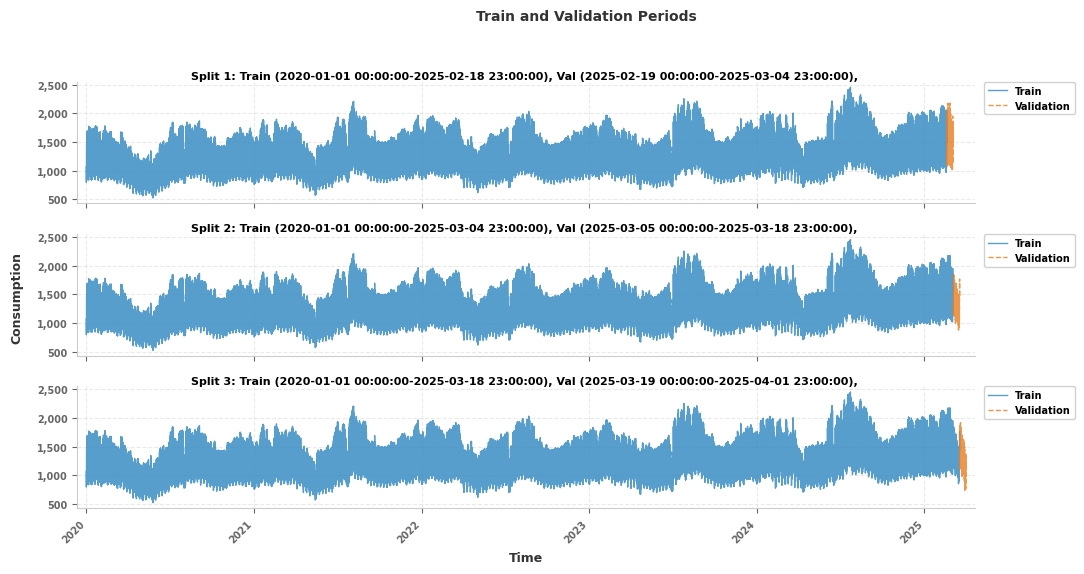

In [5]:
val_size = 336
n_splits = 3
splits_info = mtf.get_tscv_splits((train.index), n_splits=n_splits, test_size=val_size)
mtf.plot_splits(splits_info,train["consumption"])

In [6]:
mtf.print_splits_info(splits_info)

Split 1:
  Train: 2020-01-01 --> 2025-02-18
  Val:  2025-02-19 --> 2025-03-04
----------------------------------------
Split 2:
  Train: 2020-01-01 --> 2025-03-04
  Val:  2025-03-05 --> 2025-03-18
----------------------------------------
Split 3:
  Train: 2020-01-01 --> 2025-03-18
  Val:  2025-03-19 --> 2025-04-01
----------------------------------------


In [7]:
start_1 = time.time()
model_performance = {}
selected_cols = []

es = 50
verbose = 50

data = train.copy()

def objective(trial):
    model_performance[trial.number] = {}
    loss_function = trial.suggest_categorical('loss_function',['RMSE'])

    param = {   
        'iterations': trial.suggest_int('iterations', 10, 10),
        'loss_function' : loss_function,
        'eval_metric': trial.suggest_categorical('eval_metric', ['RMSE']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        "allow_writing_files": False
    }

    start_time = time.time()

    total_mape_train = 0
    total_mape_val = 0
    total_mape_unseen = 0

    split_count = len(splits_info)

    for split in splits_info:
        split_name = split['name']
        print(f"\n\nTraining on Trial: {trial.number} , {split_name}\n")
        train = data[split['train_period'][0]:split['train_period'][1]].drop(columns=selected_cols)
        val = data[split['val_period'][0]:split['val_period'][1]].drop(columns=selected_cols)
        X_train, y_train = train.drop(columns=["consumption"]), train["consumption"]
        print("Train data shape:", X_train.shape)
        print("Target length:", len(y_train))
        print("Any NaN in target:", y_train.isna().sum())
        print("Unique values in target:", y_train.unique())

        X_val, y_val = val.drop(columns=["consumption"]), val["consumption"]
        print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

        cat_cols = X_train.select_dtypes(include=["category", "object"]).columns.tolist()
        train_pool = Pool(X_train, label=y_train, cat_features=cat_cols)
        val_pool = Pool(X_val, label=y_val, cat_features=cat_cols)

        model = CatBoostRegressor(**param)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=es, verbose=verbose)

        train_result = model.predict(X_train)
        val_result = model.predict(X_val)
        unseen_predict = model.predict(unseen.drop(columns="consumption"))

        train_mape_df, train_mape = mtf.calculate_mape(y_train, train_result)
        val_mape_df, val_mape = mtf.calculate_mape(y_val, val_result)
        unseen_mape_df, unseen_mape = mtf.calculate_mape(unseen["consumption"], unseen_predict)

        total_mape_train += train_mape
        total_mape_val += val_mape
        total_mape_unseen += unseen_mape

        print(f"Score Train - {split_name}: {train_mape},\nScore Val - {split_name}: {val_mape},\nScore Unseen - {split_name}: {unseen_mape}")
        print(f'Actual Mean: {np.mean(unseen["consumption"]):.3f},\nPredicted Mean: {np.mean(unseen_predict):.3f}')
        print('*'*50,"\n")

        # Model performansını kaydetme
        model_performance[trial.number][split_name] = {
            'hyperparameters': param,
            'model': model,
            'train_mape':train_mape,
            'val_mape':val_mape,
            'unseen_mape':unseen_mape,
            'evals_result': model.get_evals_result(),
            'importance': model.get_feature_importance(),
            'train_df':train_mape_df,
            'val_df': val_mape_df,
            'unseen_df': unseen_mape_df,
            "train": train,
            "val": val,
            "unseen": unseen
        }

    val_mape_set = {}
    for col in model_performance[trial.number].keys():
        val_mape = mtf.calculate_mape(model_performance[trial.number][col]["val_df"]["Gerçek"].values,model_performance[trial.number][col]["val_df"]["Tahmin"].values)[1]
        val_mape_set[col]  = val_mape
    val_mape_set = pd.DataFrame(data=val_mape_set.items(),columns=["Split","Val_MAPE"])
    val_mape_std = np.std(val_mape_set["Val_MAPE"])
    val_mape_mean = np.mean(val_mape_set["Val_MAPE"])

    base_average_mape = total_mape_val / split_count
    print(f"Trial completed in {(time.time() - start_time) / 60:.2f} minutes with average Validation MAPE: %{val_mape_mean:.3f} and STD: %{val_mape_std:.3f}")

    return val_mape_mean

study = optuna.create_study(direction="minimize",
                            study_name="CatBoost TSS Optimization",
                            sampler=optuna.samplers.TPESampler(
                                multivariate=True,
                                seed=seed_value))
study.optimize(objective, 
               n_trials=2,
               show_progress_bar=True,
               #n_jobs=-1
              )

end_1 = time.time()
print(f"Trials completed in {(end_1 - start_1) / 60:.2f} minutes")

[I 2025-06-28 04:16:04,458] A new study created in memory with name: CatBoost TSS Optimization


  0%|          | 0/2 [00:00<?, ?it/s]



Training on Trial: 0 , Split 1

Train data shape: (45024, 273)
Target length: 45024
Any NaN in target: 0
Unique values in target: [1063.48531906  993.9808637   910.94244226 ... 1695.221883   1597.692006
 1488.911049  ]
Training data shape: (45024, 273), Validation data shape: (336, 273)
0:	learn: 303.2487676	test: 416.5825558	best: 416.5825558 (0)	total: 186ms	remaining: 1.68s
9:	learn: 244.1324869	test: 343.9729140	best: 343.9729140 (9)	total: 619ms	remaining: 0us

bestTest = 343.972914
bestIteration = 9

Score Train - Split 1: 15.38,
Score Val - Split 1: 17.71,
Score Unseen - Split 1: 13.76
Actual Mean: 1337.883,
Predicted Mean: 1314.924
************************************************** 



Training on Trial: 0 , Split 2

Train data shape: (45360, 273)
Target length: 45360
Any NaN in target: 0
Unique values in target: [1063.48531906  993.9808637   910.94244226 ... 1678.9594335  1571.3341205
 1470.973085  ]
Training data shape: (45360, 273), Validation data shape: (336, 273)
0:	lea

In [8]:
study.trials_dataframe().sort_values("value")

,number,value,datetime_start,datetime_complete,duration,params_eval_metric,params_iterations,params_learning_rate,params_loss_function,state
0,0,14.273333,2025-06-28 04:16:04.473620,2025-06-28 04:16:06.847888,0 days 00:00:02.374268,RMSE,10,0.030514,RMSE,COMPLETE
1,1,15.316667,2025-06-28 04:16:06.847888,2025-06-28 04:16:09.001579,0 days 00:00:02.153691,RMSE,10,0.021232,RMSE,COMPLETE


In [9]:
best_model_performance = (model_performance[study.best_trial.number])

In [10]:
for split in best_model_performance.keys():
    print(f"{split}")
    print(f"Train MAPE: {best_model_performance[split]['train_mape']:.2f}")
    print(f"Validation MAPE: {best_model_performance[split]['val_mape']:.2f}")
    print(f"Unseen MAPE: {best_model_performance[split]['unseen_mape']:.2f}")
    print("-" * 50)

Split 1
Train MAPE: 15.38
Validation MAPE: 17.71
Unseen MAPE: 13.76
--------------------------------------------------
Split 2
Train MAPE: 15.38
Validation MAPE: 10.96
Unseen MAPE: 13.91
--------------------------------------------------
Split 3
Train MAPE: 15.35
Validation MAPE: 14.15
Unseen MAPE: 13.57
--------------------------------------------------


In [11]:
train_mape_mean = np.mean([best_model_performance[split]['train_mape'] for split in best_model_performance.keys()])
train_mape_std = np.std([best_model_performance[split]['train_mape'] for split in best_model_performance.keys()])
val_mape_mean = np.mean([best_model_performance[split]['val_mape'] for split in best_model_performance.keys()])
val_mape_std = np.std([best_model_performance[split]['val_mape'] for split in best_model_performance.keys()])
unseen_mape_mean = np.mean([best_model_performance[split]['unseen_mape'] for split in best_model_performance.keys()])
unseen_mape_std = np.std([best_model_performance[split]['unseen_mape'] for split in best_model_performance.keys()])

print("Train MAPE: Ortalama {:.2f}, Standart Sapma {:.2f}".format(train_mape_mean, train_mape_std))
print("Train MAPE Dağılımı",[float(best_model_performance[split]['train_mape']) for split in best_model_performance])
print("*"*50)
print("Validation MAPE: Ortalama {:.2f}, Standart Sapma {:.2f}".format(val_mape_mean, val_mape_std))
print("Validation MAPE Dağılımı",[float(best_model_performance[split]['val_mape']) for split in best_model_performance])
print("*"*50)
print("Unseen MAPE: Ortalama {:.2f}, Standart Sapma {:.2f}".format(unseen_mape_mean, unseen_mape_std))
print("Unseen MAPE Dağılımı",[float(best_model_performance[split]['unseen_mape']) for split in best_model_performance])
print("*"*50)

Train MAPE: Ortalama 15.37, Standart Sapma 0.01
Train MAPE Dağılımı [15.38, 15.38, 15.35]
**************************************************
Validation MAPE: Ortalama 14.27, Standart Sapma 2.76
Validation MAPE Dağılımı [17.71, 10.96, 14.15]
**************************************************
Unseen MAPE: Ortalama 13.75, Standart Sapma 0.14
Unseen MAPE Dağılımı [13.76, 13.91, 13.57]
**************************************************


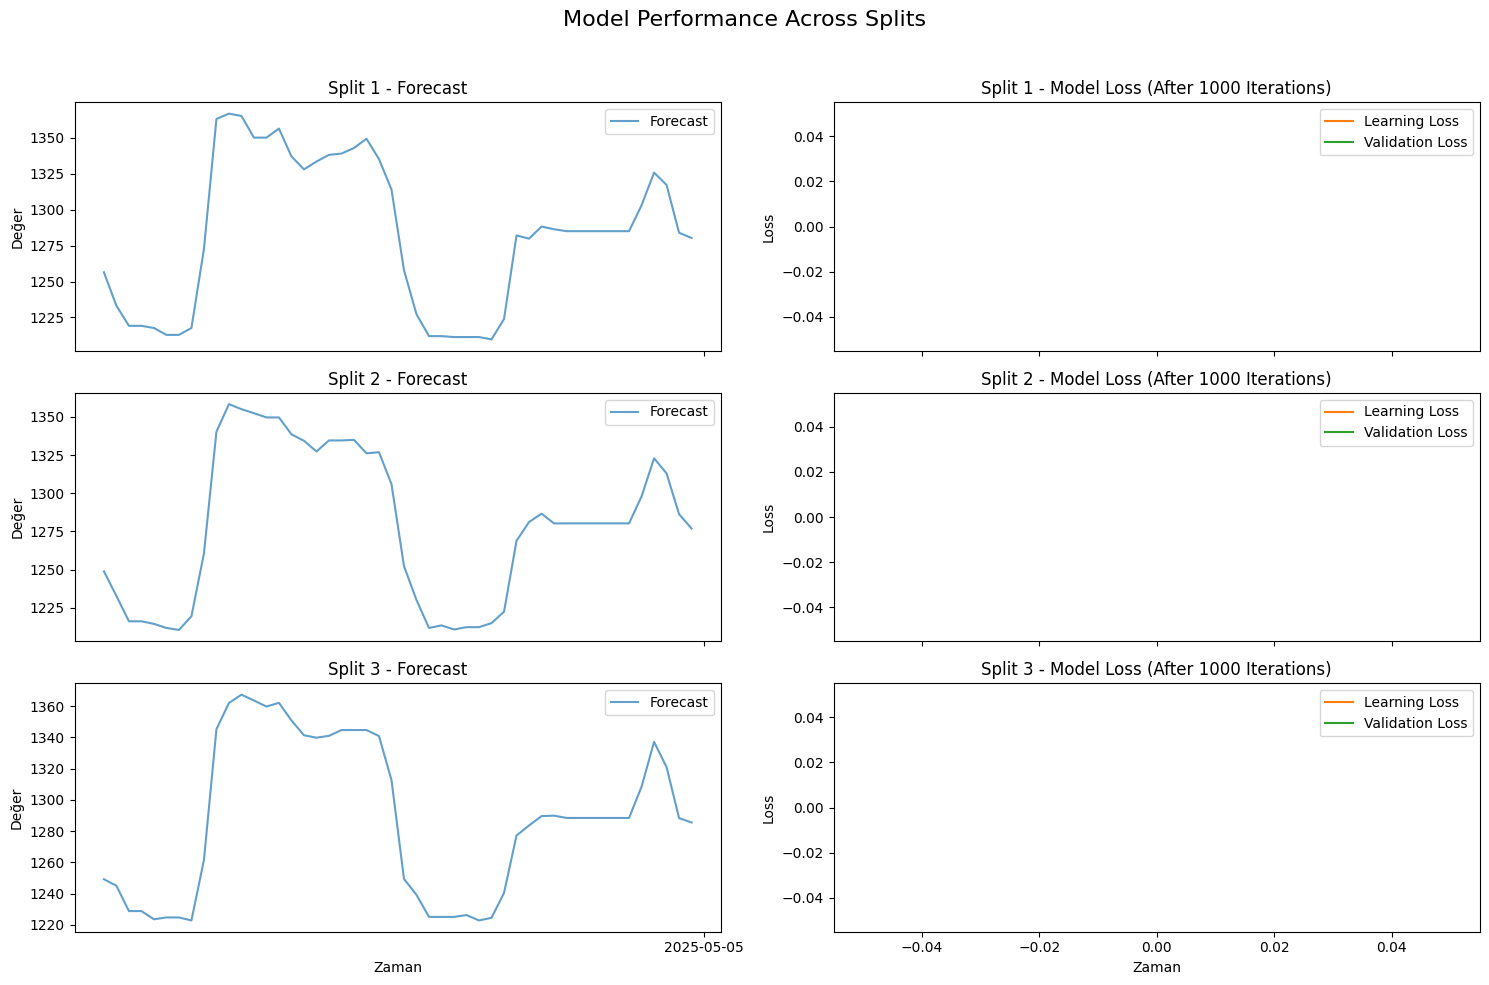

In [12]:
X_forecast = forecast.drop("consumption",axis=1)
model_result = pd.DataFrame(index=X_forecast.index)
X_forecast = X_forecast.drop(columns=selected_cols)
X_forecast = cb.Pool(X_forecast, cat_features=cat_cols)

learn_metric = best_model_performance["Split 1"]["hyperparameters"]['eval_metric']

after_iter = 1000
fig, axs = plt.subplots(len(best_model_performance.keys()), 2, figsize=(15, 10), sharex='col')
fig.suptitle("Model Performance Across Splits", fontsize=16)
split_names = [col for col in best_model_performance.keys() if "Split" in col]

for i, split in enumerate(split_names):
    modelx = best_model_performance[split]["model"]
    history = best_model_performance[split]["evals_result"]

    # 1. Forecast Plot
    forecast_predictions = modelx.predict(X_forecast)
    model_result[split] = forecast_predictions

    date_range = pd.to_datetime(forecast.index)

    axs[i, 0].plot(date_range, forecast_predictions, label='Forecast', color='tab:blue', alpha=0.7)
    axs[i, 0].set_title(f'{split} - Forecast')
    axs[i, 0].set_ylabel('Değer')
    axs[i, 0].legend()
    axs[i, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axs[i, 0].xaxis.set_major_locator(mdates.DayLocator(interval=5))

    # 2. Model Loss Plot
    axs[i, 1].plot(history['learn'][learn_metric][after_iter:], label='Learning Loss', color='tab:orange')
    axs[i, 1].plot(history['validation'][learn_metric][after_iter:], label='Validation Loss', color='tab:green')
    axs[i, 1].set_title(f'{split} - Model Loss (After {after_iter} Iterations)')
    axs[i, 1].set_ylabel('Loss')
    axs[i, 1].legend()

# Genel ayarlamalar
for ax in axs[-1, :]:  # Son satırın x ekseninde tarih formatı ayarı
    ax.set_xlabel('Zaman')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

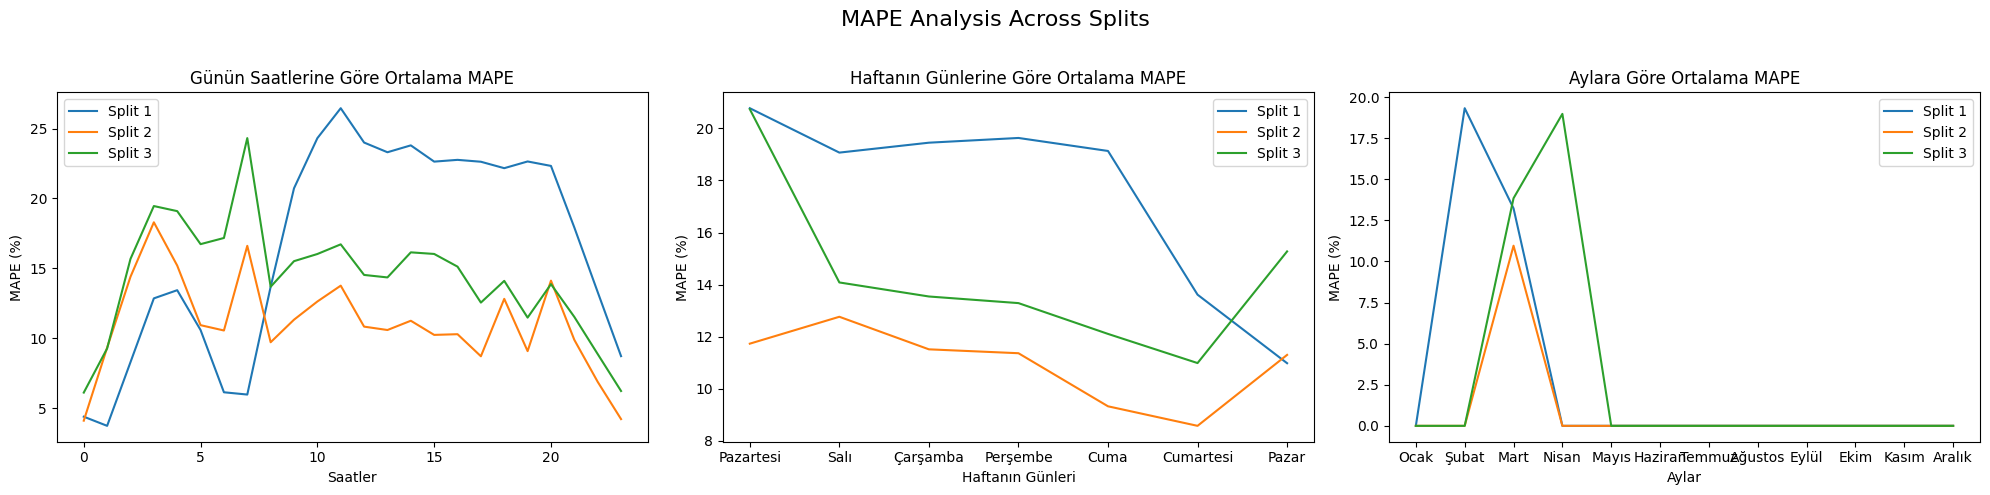

In [13]:
mtf.all_splits_mape_analysis(best_model_performance)

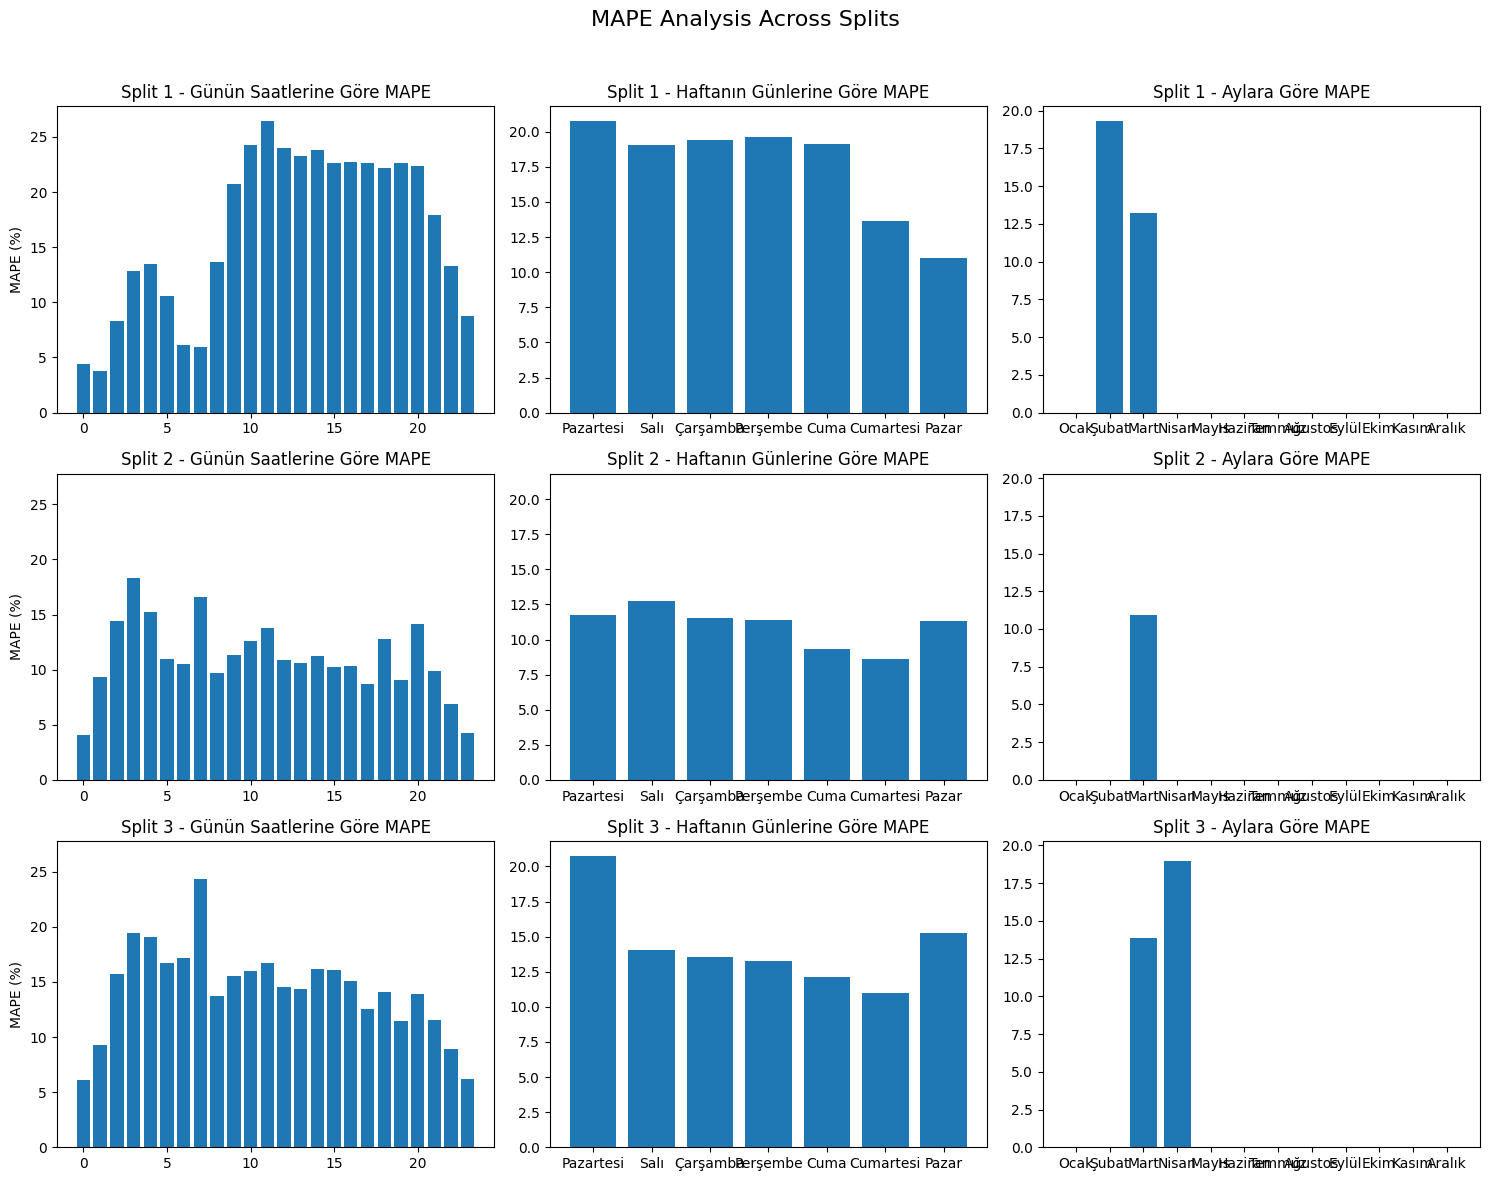

In [14]:
mtf.all_splits_mape_analysis_v2(best_model_performance)

In [17]:
predicts = {}

split_names = [col for col in best_model_performance.keys() if "Split" in col]
for split in split_names:
  split_model = (best_model_performance[split]["model"])
  split_predict = split_model.predict(best_model_performance[split_names[-1]]["unseen"].drop(columns="consumption"))
  predicts[split] = split_predict
predicts = pd.DataFrame(predicts)

predicts.index = best_model_performance[split_names[-1]]["unseen_df"].index
predicts["Gerçek"] = best_model_performance[split_names[-1]]["unseen_df"]["Gerçek"].values

mape_scores = {}
for col in predicts.columns:
    mape_scores[col] = mtf.calculate_mape(predicts["Gerçek"], predicts[col])[1]
all_mape_df = pd.DataFrame(mape_scores.items(), columns=["Model", "Unseen Mape"]).iloc[:-1,:]
all_mape_df["Validation Mape"] = [best_model_performance[split]['val_mape'] for split in best_model_performance.keys()]

all_mape_df

,Model,Unseen Mape,Validation Mape
0,Split 1,13.76,17.71
1,Split 2,13.91,10.96
2,Split 3,13.57,14.15


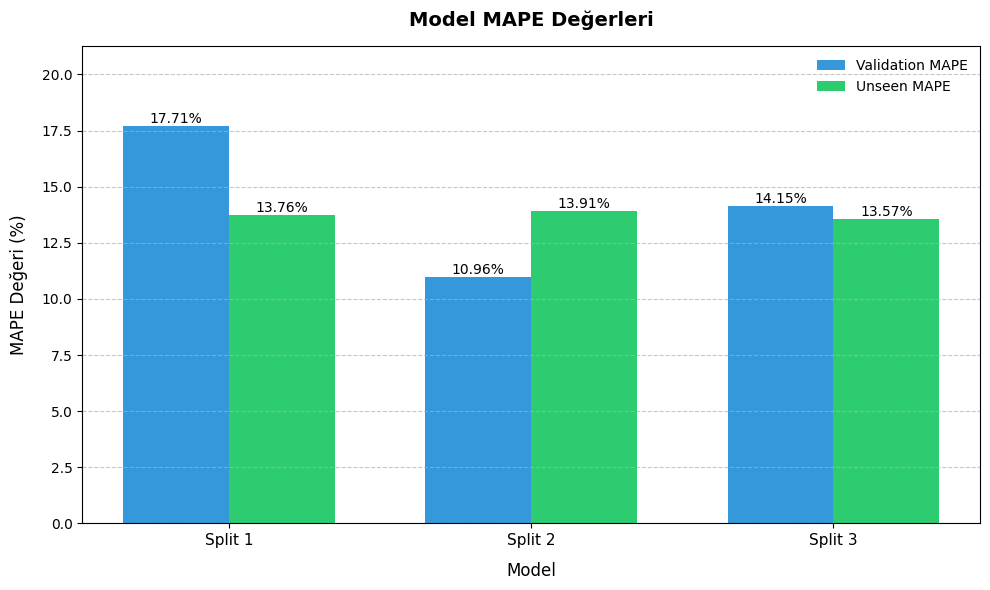

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

# Çubuk genişliği ve konum ayarları
bar_width = 0.35
index = all_mape_df.index

# Çubuk grafikleri çiz
bars1 = ax.bar(index - bar_width / 2, all_mape_df['Validation Mape'], bar_width, color='#3498db', label='Validation MAPE')
bars2 = ax.bar(index + bar_width / 2, all_mape_df['Unseen Mape'], bar_width, color='#2ecc71', label='Unseen MAPE')

# Başlık ve etiketler
ax.set_title('Model MAPE Değerleri', pad=15, fontsize=14, fontweight='bold')
ax.set_xlabel('Model', fontsize=12, labelpad=10)
ax.set_ylabel('MAPE Değeri (%)', fontsize=12, labelpad=10)

# X ekseni etiketlerini düzenle
ax.set_xticks(index)
ax.set_xticklabels(all_mape_df['Model'], fontsize=11)

# Y eksenini çerçeveye sığdır
ax.set_ylim(0, max(all_mape_df['Validation Mape'].max(), all_mape_df['Unseen Mape'].max()) * 1.2)

# Izgara çizgileri
ax.grid(True, linestyle='--', alpha=0.7, axis='y')

# Çubukların üstüne değer yaz
for bars, label in zip([bars1, bars2], ['Validation Mape', 'Unseen Mape']):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

# Lejant
ax.legend(loc='upper right', fontsize=10, frameon=False)

# Layout ayarları
fig.tight_layout()

# Grafiği göster
plt.show()


In [21]:
for split in best_model_performance.keys():
    r2 = r2_score(best_model_performance[split]["unseen_df"]["Gerçek"],best_model_performance[split]["unseen_df"]["Tahmin"])
    
    # Veri ve değişken sayısı
    n = len(best_model_performance[split]["unseen_df"])          # Veri noktalarının sayısı
    p = best_model_performance[split]["unseen_df"].shape[1]      # Bağımsız değişkenlerin sayısı
    
    # Adjusted R² hesaplama
    adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    
    print(f"{split}          R²: {r2:.4f}")
    print(f"{split} Adjusted R²: {adjusted_r2:.4f}")
    print("\n")

Split 1          R²: 0.3371
Split 1 Adjusted R²: 0.3345


Split 2          R²: 0.3206
Split 2 Adjusted R²: 0.3178


Split 3          R²: 0.3459
Split 3 Adjusted R²: 0.3432




In [22]:
"T V U --M {:.2f}, {:.2f}, {:.2f} ---- T V U--S {:.2f}, {:.2f}, {:.2f}".format(train_mape_mean,val_mape_mean,unseen_mape_mean,
                                                                                   train_mape_std,val_mape_std,unseen_mape_std)

'T V U --M 15.37, 14.27, 13.75 ---- T V U--S 0.01, 2.76, 0.14'

In [33]:
model_ımp = best_model_performance["Split 3"]["model"].get_feature_importance(prettified=True,type='LossFunctionChange',data=Pool(historical_data.drop(columns="consumption"),
                                                                                                                                         historical_data["consumption"],cat_features=cat_cols))
model_ımp.loc[model_ımp.Importances > 1]["Feature Id"].tolist()

['date_hour',
 'GercekTuketim_lag_168',
 'PK-Ticarethane - AG',
 'YukTahmin_lag_168',
 'PK-Ticarethane - OG',
 'KGUP_window_48_mean',
 'GercekTuketim_lag_48',
 'azimuth',
 'YukTahmin_lag_48',
 'PK-Sanayi-OG',
 'PK-Sanayi-AG',
 'GopAlis_lag_168',
 'PK-Mesken - OG',
 'azimuth_radian',
 'temp_lag_24h_canakkale']

In [37]:

joblib.dump(best_model_performance,f'C:/Users/pc/Desktop/ULUDAG-ENERJI-DAGITILAN/models/'+"T V U --M {:.2f}, {:.2f}, {:.2f} ---- T V U--S {:.2f}, {:.2f}, {:.2f}".format(train_mape_mean,val_mape_mean,unseen_mape_mean,
                                                                                   train_mape_std,val_mape_std,unseen_mape_std)+'.joblib')

['C:/Users/pc/Desktop/ULUDAG-ENERJI-DAGITILAN/models/T V U --M 15.37, 14.27, 13.75 ---- T V U--S 0.01, 2.76, 0.14.joblib']

In [45]:
exp_model = best_model_performance["Split 3"]["model"]
exp_model.save_model("C:/Users/pc/Desktop/ULUDAG-ENERJI-DAGITILAN/models/exp_model.cbm", format="cbm")